<a href="https://colab.research.google.com/github/haoboooo/Temporal-Generalization-of-Sentiment-Analysis-on-Amazon-Reviews/blob/main/video_games/game_finetune_adapter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install emot
!pip install -U adapter-transformers
!pip install datasets

     |████████████████████████████████| 61 kB 11 kB/s 
     |████████████████████████████████| 3.9 MB 4.3 MB/s 
     |████████████████████████████████| 596 kB 70.6 MB/s 
     |████████████████████████████████| 6.6 MB 47.7 MB/s 
     |████████████████████████████████| 880 kB 25.3 MB/s 
     |████████████████████████████████| 84 kB 4.0 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=b5195069dfca36737fb3b479ec037910d84447326ac10dbc1b40eece90ae9aef
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 346 kB 4.2 MB/s 
     |████████████████████████████████| 1.1 MB 60.9 MB/s 
     |████████████████████████████████| 140 kB 77.1 MB/s 
     |████████████████████████████████|

In [ ]:
import pandas as pd
import numpy as np
import string
import os

# text preprocessing
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
import re
from emot.emo_unicode import EMOTICONS_EMO, UNICODE_EMOJI

# plots and metrics
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
from sklearn.metrics import accuracy_score, f1_score

import torch
from transformers import RobertaTokenizer
import datasets
from datasets import Dataset
from transformers import RobertaConfig, RobertaModelWithHeads
from transformers import TrainingArguments, AdapterTrainer, EvalPrediction

In [ ]:
nltk.download("stopwords")
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## load game data

In [ ]:
file1 = "./drive/MyDrive/Colab Notebooks/CL/game/97_06.csv"
file2 = "./drive/MyDrive/Colab Notebooks/CL/game/07_12.csv"
file3 = "./drive/MyDrive/Colab Notebooks/CL/game/13_17.csv"
file4 = "./drive/MyDrive/Colab Notebooks/CL/game/18.csv"

In [ ]:
def load_data(file):
  # read csv data and set columns
  df = pd.read_csv(file,usecols=['overall', 'reviewTime','reviewText'])

  # remove the duplicates if any
  df.duplicated('reviewText').sum()
  df.drop_duplicates(subset=['reviewText'],inplace=True)
  
  # remove NaN rows
  df.isnull().sum()
  df.dropna(how='any',axis=0,inplace=True)
  shape = df.shape
  counts = df.overall.value_counts()# labels count

  sns.countplot(df['overall']) # plot bar graph
  fig = plt.gcf() # get current figure
  fig.set_size_inches(5,5) # set the figure size
  plt.title('overall') # add title to the figure

  return df,shape,counts

(95385, 3)
 1.0    69406
-1.0    18035
 0.0     7944
Name: overall, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


,overall,reviewTime,reviewText
0,1.0,2006,This game is a good time. Especially if you h...
1,0.0,2005,Don't expect the bells and whistles that you f...
2,1.0,2005,"It is fun to play this game, I really like it...."
3,1.0,2006,Here's the deal with this item: it's fine for ...
4,0.0,2006,We bought this for Christmas for our three kid...


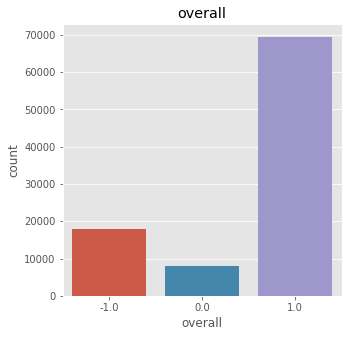

In [ ]:
# load data for 1997 - 2006
df1,shape1,counts1 = load_data(file1)
print(shape1)
print(counts1)
df1.head()

(273501, 3)
 1.0    193149
-1.0     55507
 0.0     24845
Name: overall, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


,overall,reviewTime,reviewText
0,1.0,2012,I oredered this for a daughter who is now 33 a...
1,1.0,2010,Well I thought since this idem didn't have any...
2,1.0,2012,Good game. Good graphics. A bit of a learning ...
3,-1.0,2012,"If you buy this game, you will regret it. If ..."
4,1.0,2012,4 Stars because they like it and play it often...


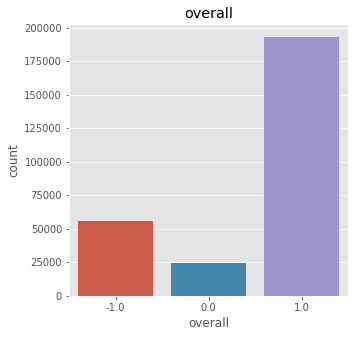

In [ ]:
# load data for 2007 - 2012
df2,shape2,counts2 = load_data(file2)
print(shape2)
print(counts2)
df2.head()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(957163, 3)
 1.0    672584
-1.0    210099
 0.0     74480
Name: overall, dtype: int64


,overall,reviewTime,reviewText
0,-1.0,2014,I used to play this game years ago and loved i...
1,0.0,2014,The game itself worked great but the story lin...
2,1.0,2014,I had to learn the hard way after ordering thi...
3,-1.0,2014,The product description should state this clea...
4,1.0,2014,I would recommend this learning game for anyon...


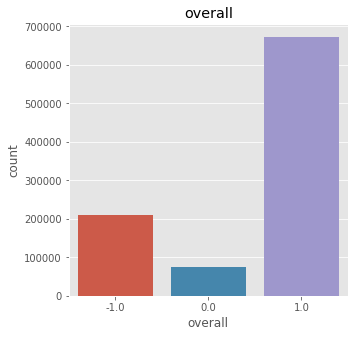

In [ ]:
# load data for 2013 - 2017
df3,shape3,counts3 = load_data(file3)
print(shape3)
print(counts3)
df3.head()

(80396, 3)
 1.0    52744
-1.0    21618
 0.0     6034
Name: overall, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


,overall,reviewTime,reviewText
0,1.0,2018,No complaints! Sing your little heart out!
1,1.0,2018,Works great with Xbox 360. I have 2 of these u...
2,1.0,2018,The game was perfect and super clean. Very ple...
3,1.0,2018,It was perfect gift. Got it for Christmas and ...
4,1.0,2018,Lik3d it


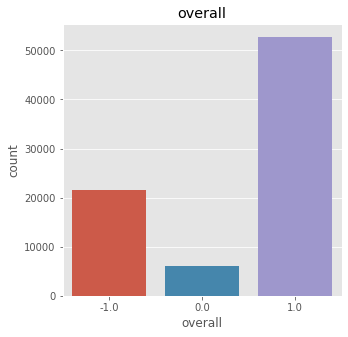

In [ ]:
# load data for 2018
df4,shape4,counts4 = load_data(file4)
print(shape4)
print(counts4)
df4.head()

## Split and Balance train&test

Balance each time period for 
5000 positive，5000 negative，5000 neutral

80%(12000) training and 20%(3000) testing

In [ ]:
def split_balance(df):
  # get data of each class
  groups = df.groupby(df.overall)
  pos = groups.get_group(1)
  neu = groups.get_group(0)
  neg = groups.get_group(-1)

  # shuffle the dataframe
  pos = pos.sample(frac=1.0)
  neu = neu.sample(frac=1.0)
  neg = neg.sample(frac=1.0)

  # split to get train for each class
  train_posdata = pos.iloc[:4000,:]
  train_neudata = neu.iloc[:4000,:]
  train_negdata = neg.iloc[:4000,:]

  # split to get test for each class
  test_posdata = pos.iloc[4000:5000,:]
  test_neudata = neu.iloc[4000:5000,:]
  test_negdata = neg.iloc[4000:5000,:]

  train = pd.concat([train_posdata, train_neudata, train_negdata],sort=False).sample(frac=1.0)
  test = pd.concat([test_posdata, test_neudata, test_negdata],sort=False).sample(frac=1.0)

  return train,test

In [ ]:
# data for 1997 - 2006
df1_train,df1_test = split_balance(df1)

# data for 2007 - 2012
df2_train,df2_test = split_balance(df2)

# data for 2013 - 2017
df3_train,df3_test = split_balance(df3)

# data for 2018
df4_train,df4_test = split_balance(df4)

In [ ]:
df1_train["overall"] = df1_train["overall"].replace(-1,2)
df1_test["overall"] = df1_test["overall"].replace(-1,2)

df2_train["overall"] = df2_train["overall"].replace(-1,2)
df2_test["overall"] = df2_test["overall"].replace(-1,2)

df3_train["overall"] = df3_train["overall"].replace(-1,2)
df3_test["overall"] = df3_test["overall"].replace(-1,2)

df4_train["overall"] = df4_train["overall"].replace(-1,2)
df4_test["overall"] = df4_test["overall"].replace(-1,2)

In [ ]:
df1_test.shape

(3000, 3)

## Text Preprocessing

In [ ]:
# get stopwords from txt
def get_stop_words(txt):
    #read the stop words
    with open(txt,'r') as f:
        stopwords_list=f.readlines()
    for i in range (0,len(stopwords_list)):
        stopwords_list[i]=stopwords_list[i].replace('\n','')
    return stopwords_list

In [ ]:
# Defining my NLTK stop words and my user-defined stop words
stop_words = list(stopwords.words('english'))
alphabets = list(string.ascii_lowercase) # 26 letters with lowercase
user_stop_words = get_stop_words("./drive/MyDrive/Colab Notebooks/CL/stopwords.txt")
stop_words = stop_words+alphabets+user_stop_words
emojis = {**UNICODE_EMOJI,**EMOTICONS_EMO} # full list of emojis unicodes

In [ ]:
def processtext(txt):
  # replace all emojis
  for emo in emojis.keys():
    txt = txt.replace(emo,"EMOJI "+emojis[emo])
  
  txt = txt.replace('\r', '').replace('\n', ' ')
  # remove all html tag
  txt = re.sub("(<.*?>)", "", txt)
  # remove all urls
  txt = re.sub('https?:\/\/\S+','',txt)
  # remove @ references  
  txt = re.sub('@[\w_]+','',txt)
  # remove # hashtags
  txt = re.sub('#\S+','',txt)
  # replace digits with no space
  txt = re.sub(r"\d", '',txt)
  # convert tweet to lower case
  txt = txt.lower()
  # remove all multiple white spaces
  txt = re.sub('[\s]+',' ',txt)
  # remove all punctuations and non-ascii
  txt = re.sub('[\.?!,;:\-\[\]\{\}\(\)\'\"/]','',txt)
  txt = txt.replace('$','').replace('&','')
  # remove whitespace
  txt = txt.strip()

  tokens = word_tokenize(txt)
  filtered_words = [w for w in tokens if w not in stop_words]
  # filtered_words = [w for w in filtered_words if w in word_list]
  return " ".join(filtered_words)

In [ ]:
df1_train["cleanText"] = df1_train["reviewText"].apply(processtext)
df1_test["cleanText"] = df1_test["reviewText"].apply(processtext)

df2_train["cleanText"] = df2_train["reviewText"].apply(processtext)
df2_test["cleanText"] = df2_test["reviewText"].apply(processtext)

df3_train["cleanText"] = df3_train["reviewText"].apply(processtext)
df3_test["cleanText"] = df3_test["reviewText"].apply(processtext)

df4_train["cleanText"] = df4_train["reviewText"].apply(processtext)
df4_test["cleanText"] = df4_test["reviewText"].apply(processtext)

## Tokenization

In [ ]:
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

def encode_batch(batch):
  """Encodes a batch of input data using the model tokenizer."""
  return tokenizer(batch["text"], max_length=128, truncation=True, padding="max_length")

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [ ]:
def generate_datasetdict(dataframe1,dataframe2):
  text1 = dataframe1.cleanText.values
  text2 = dataframe2.cleanText.values

  label1 = dataframe1.overall.values.astype(np.int32)
  label2 = dataframe2.overall.values.astype(np.int32)

  train_df = pd.DataFrame({"label" : label1,"text" : text1})
  test_df = pd.DataFrame({"label" : label2,"text" : text2})

  train_dataset = Dataset.from_dict(train_df)
  test_dataset = Dataset.from_dict(test_df)
  my_dataset_dict = datasets.DatasetDict({"train":train_dataset,"test":test_dataset})

  # Encode the input data
  dataset = my_dataset_dict.map(encode_batch, batched=True)
  # The transformers model expects the target class column to be named "labels"
  # dataset.rename_column(original_column_name="label", new_column_name="labels")
  # Transform to pytorch tensors and only output the required columns
  dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

  return dataset

In [ ]:
df1_dataset = generate_datasetdict(df1_train,df1_test)
df2_dataset = generate_datasetdict(df2_train,df2_test)
df3_dataset = generate_datasetdict(df3_train,df3_test)
df4_dataset = generate_datasetdict(df4_train,df4_test)

  0%|          | 0/12 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/12 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/12 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/12 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

## Train Adapters

### adapter learning from 1997-2006

In [ ]:
config = RobertaConfig.from_pretrained(
    "roberta-base",
    num_labels=3,
)
model = RobertaModelWithHeads.from_pretrained(
    "roberta-base",
    config=config,
)

/usr/local/lib/python3.7/dist-packages/transformers/adapters/models/roberta.py:255: FutureWarning: This class has been renamed to `RobertaAdapterModel` in v3. Please use the new class instead as this class might be removed in a future version.
  FutureWarning,


Downloading:   0%|          | 0.00/478M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/transformers/adapters/models/roberta.py:233: FutureWarning: This class has been renamed to `RobertaAdapterModel` in v3. Please use the new class instead as this class might be removed in a future version.
  FutureWarning,
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModelWithHeads: ['lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModelWithHeads from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModelWithHeads from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weig

In [ ]:
# Add a new adapter
model.add_adapter("amazon_review")
# Add a matching classification head
model.add_classification_head(
    "amazon_review",
    num_labels=3,
    id2label={ 0: "neutral", 1: "positive", 2: "negative"}
  )
# Activate the adapter
model.train_adapter("amazon_review")

In [ ]:
training_args = TrainingArguments(
    learning_rate=1e-4,
    num_train_epochs=6,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    logging_steps=200,
    output_dir="./training_output",
    overwrite_output_dir=True,
    # The next line is important to ensure the dataset labels are properly passed to the model
    remove_unused_columns=False,
)

def compute_accuracy(p: EvalPrediction):
  preds = np.argmax(p.predictions, axis=1)
  return {"acc": (preds == p.label_ids).mean()}

trainer = AdapterTrainer(
    model=model,
    args=training_args,
    train_dataset=df1_dataset["train"],
    eval_dataset=df1_dataset["test"],
    compute_metrics=compute_accuracy,
)

In [ ]:
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 12000
  Num Epochs = 6
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 2250


Step,Training Loss
200,0.938000
400,0.802400
600,0.752800
800,0.742200
1000,0.718600
1200,0.710700
1400,0.699100
1600,0.680200
1800,0.681100
2000,0.657200


Saving model checkpoint to ./training_output/checkpoint-500
Configuration saved in ./training_output/checkpoint-500/amazon_review/adapter_config.json
Module weights saved in ./training_output/checkpoint-500/amazon_review/pytorch_adapter.bin
Configuration saved in ./training_output/checkpoint-500/amazon_review/head_config.json
Module weights saved in ./training_output/checkpoint-500/amazon_review/pytorch_model_head.bin
Configuration saved in ./training_output/checkpoint-500/amazon_review/head_config.json
Module weights saved in ./training_output/checkpoint-500/amazon_review/pytorch_model_head.bin
Saving model checkpoint to ./training_output/checkpoint-1000
Configuration saved in ./training_output/checkpoint-1000/amazon_review/adapter_config.json
Module weights saved in ./training_output/checkpoint-1000/amazon_review/pytorch_adapter.bin
Configuration saved in ./training_output/checkpoint-1000/amazon_review/head_config.json
Module weights saved in ./training_output/checkpoint-1000/amazon_

TrainOutput(global_step=2250, training_loss=0.7295760701497396, metrics={'train_runtime': 604.716, 'train_samples_per_second': 119.064, 'train_steps_per_second': 3.721, 'total_flos': 4818162714624000.0, 'train_loss': 0.7295760701497396, 'epoch': 6.0})

In [ ]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 3000
  Batch size = 32


{'epoch': 6.0,
 'eval_acc': 0.689,
 'eval_loss': 0.7149116396903992,
 'eval_runtime': 12.6281,
 'eval_samples_per_second': 237.565,
 'eval_steps_per_second': 7.444}

In [ ]:
trainer.predict(df2_dataset["test"])

***** Running Prediction *****
  Num examples = 3000
  Batch size = 32


PredictionOutput(predictions=array([[ 0.57732534,  1.5332363 , -2.7260172 ],
       [ 0.6276494 ,  0.27783588, -1.1114018 ],
       [ 0.534029  , -1.5198189 ,  1.0291219 ],
       ...,
       [-0.0390754 ,  1.8691002 , -2.2700295 ],
       [-0.29241967,  2.6136758 , -2.8840482 ],
       [-0.69231766,  0.3743754 , -0.05790519]], dtype=float32), label_ids=array([1, 0, 0, ..., 2, 1, 2]), metrics={'test_loss': 0.7282891273498535, 'test_acc': 0.6773333333333333, 'test_runtime': 12.6564, 'test_samples_per_second': 237.034, 'test_steps_per_second': 7.427})

In [ ]:
trainer.predict(df3_dataset["test"])

***** Running Prediction *****
  Num examples = 3000
  Batch size = 32


PredictionOutput(predictions=array([[ 0.29828453,  0.5635446 , -1.1221933 ],
       [ 0.13280249, -2.1603372 ,  2.0965772 ],
       [-0.41683102, -0.75087196,  1.1357249 ],
       ...,
       [ 0.9034349 ,  0.18372205, -1.4041333 ],
       [-0.5998044 ,  2.4868135 , -2.3119116 ],
       [ 0.10912711, -1.3471982 ,  1.3846632 ]], dtype=float32), label_ids=array([0, 2, 2, ..., 0, 1, 2]), metrics={'test_loss': 0.7544754147529602, 'test_acc': 0.6673333333333333, 'test_runtime': 12.6713, 'test_samples_per_second': 236.755, 'test_steps_per_second': 7.418})

In [ ]:
trainer.predict(df4_dataset["test"])

***** Running Prediction *****
  Num examples = 3000
  Batch size = 32


PredictionOutput(predictions=array([[ 0.9483702 , -1.3354068 ,  0.23203468],
       [ 0.16880727, -2.548554  ,  2.526834  ],
       [-0.12223918, -1.562664  ,  2.0305736 ],
       ...,
       [-1.663923  ,  2.7690997 , -1.6618183 ],
       [ 0.8773817 ,  0.0563    , -1.089933  ],
       [ 0.24798107,  1.5342007 , -2.0770488 ]], dtype=float32), label_ids=array([1, 0, 2, ..., 1, 1, 1]), metrics={'test_loss': 0.7766768932342529, 'test_acc': 0.6516666666666666, 'test_runtime': 12.6362, 'test_samples_per_second': 237.414, 'test_steps_per_second': 7.439})

### adapter finetuning from 2007-2012

In [ ]:
trainer2 = AdapterTrainer(
    model=model,
    args=training_args,
    train_dataset=df2_dataset["train"],
    eval_dataset=df2_dataset["test"],
    compute_metrics=compute_accuracy,
)

In [ ]:
trainer2.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 12000
  Num Epochs = 6
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 2250


Step,Training Loss
200,0.735100
400,0.734700
600,0.701500
800,0.688800
1000,0.685500
1200,0.662500
1400,0.657200
1600,0.648900
1800,0.653800
2000,0.627100


Saving model checkpoint to ./training_output/checkpoint-500
Configuration saved in ./training_output/checkpoint-500/amazon_review/adapter_config.json
Module weights saved in ./training_output/checkpoint-500/amazon_review/pytorch_adapter.bin
Configuration saved in ./training_output/checkpoint-500/amazon_review/head_config.json
Module weights saved in ./training_output/checkpoint-500/amazon_review/pytorch_model_head.bin
Configuration saved in ./training_output/checkpoint-500/amazon_review/head_config.json
Module weights saved in ./training_output/checkpoint-500/amazon_review/pytorch_model_head.bin
Saving model checkpoint to ./training_output/checkpoint-1000
Configuration saved in ./training_output/checkpoint-1000/amazon_review/adapter_config.json
Module weights saved in ./training_output/checkpoint-1000/amazon_review/pytorch_adapter.bin
Configuration saved in ./training_output/checkpoint-1000/amazon_review/head_config.json
Module weights saved in ./training_output/checkpoint-1000/amazon_

TrainOutput(global_step=2250, training_loss=0.6737791578504775, metrics={'train_runtime': 603.3456, 'train_samples_per_second': 119.335, 'train_steps_per_second': 3.729, 'total_flos': 4818162714624000.0, 'train_loss': 0.6737791578504775, 'epoch': 6.0})

In [ ]:
trainer2.evaluate()

***** Running Evaluation *****
  Num examples = 3000
  Batch size = 32


{'epoch': 6.0,
 'eval_acc': 0.7103333333333334,
 'eval_loss': 0.6885875463485718,
 'eval_runtime': 12.5949,
 'eval_samples_per_second': 238.192,
 'eval_steps_per_second': 7.463}

In [ ]:
trainer2.predict(df1_dataset["test"])

***** Running Prediction *****
  Num examples = 3000
  Batch size = 32


PredictionOutput(predictions=array([[-0.30405033, -2.821201  ,  3.59527   ],
       [ 0.67007107, -1.4138175 ,  0.99161947],
       [ 1.7069794 , -2.1926458 ,  0.6222209 ],
       ...,
       [-1.112938  , -2.407944  ,  4.0073795 ],
       [ 1.2099911 ,  0.35460064, -1.7888215 ],
       [ 1.0922402 ,  0.36648318, -1.7197195 ]], dtype=float32), label_ids=array([2, 1, 1, ..., 1, 0, 0]), metrics={'test_loss': 0.7153077721595764, 'test_acc': 0.6833333333333333, 'test_runtime': 12.6175, 'test_samples_per_second': 237.764, 'test_steps_per_second': 7.45})

In [ ]:
trainer2.predict(df3_dataset["test"])

***** Running Prediction *****
  Num examples = 3000
  Batch size = 32


PredictionOutput(predictions=array([[ 0.56991756,  0.77148885, -1.5774574 ],
       [-0.04130555, -1.5752662 ,  1.7883022 ],
       [-0.23376454, -0.6092055 ,  0.7836422 ],
       ...,
       [ 1.1492645 ,  0.38800725, -1.8346162 ],
       [-0.22013934,  2.566844  , -2.8955972 ],
       [ 0.2351584 , -1.6201519 ,  1.6015978 ]], dtype=float32), label_ids=array([0, 2, 2, ..., 0, 1, 2]), metrics={'test_loss': 0.7094846963882446, 'test_acc': 0.698, 'test_runtime': 12.6296, 'test_samples_per_second': 237.536, 'test_steps_per_second': 7.443})

In [ ]:
trainer2.predict(df4_dataset["test"])

***** Running Prediction *****
  Num examples = 3000
  Batch size = 32


PredictionOutput(predictions=array([[ 0.920439  , -1.4780673 ,  0.65340996],
       [ 0.2619242 , -2.6181476 ,  2.665559  ],
       [ 0.42804492, -1.7922384 ,  1.7798269 ],
       ...,
       [-1.4680612 ,  3.712258  , -2.956467  ],
       [ 0.7925289 ,  0.9368411 , -2.0112808 ],
       [ 0.21964891,  1.9696115 , -2.4618106 ]], dtype=float32), label_ids=array([1, 0, 2, ..., 1, 1, 1]), metrics={'test_loss': 0.7080714702606201, 'test_acc': 0.6883333333333334, 'test_runtime': 12.6498, 'test_samples_per_second': 237.157, 'test_steps_per_second': 7.431})

### adapter finetuning from 2013-2017

In [ ]:
trainer3 = AdapterTrainer(
    model=model,
    args=training_args,
    train_dataset=df3_dataset["train"],
    eval_dataset=df3_dataset["test"],
    compute_metrics=compute_accuracy,
)

In [ ]:
trainer3.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 12000
  Num Epochs = 6
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 2250


Step,Training Loss
200,0.705000
400,0.683600
600,0.658500
800,0.650800
1000,0.621200
1200,0.627300
1400,0.619700
1600,0.598600
1800,0.606200
2000,0.588900


Saving model checkpoint to ./training_output/checkpoint-500
Configuration saved in ./training_output/checkpoint-500/amazon_review/adapter_config.json
Module weights saved in ./training_output/checkpoint-500/amazon_review/pytorch_adapter.bin
Configuration saved in ./training_output/checkpoint-500/amazon_review/head_config.json
Module weights saved in ./training_output/checkpoint-500/amazon_review/pytorch_model_head.bin
Configuration saved in ./training_output/checkpoint-500/amazon_review/head_config.json
Module weights saved in ./training_output/checkpoint-500/amazon_review/pytorch_model_head.bin
Saving model checkpoint to ./training_output/checkpoint-1000
Configuration saved in ./training_output/checkpoint-1000/amazon_review/adapter_config.json
Module weights saved in ./training_output/checkpoint-1000/amazon_review/pytorch_adapter.bin
Configuration saved in ./training_output/checkpoint-1000/amazon_review/head_config.json
Module weights saved in ./training_output/checkpoint-1000/amazon_

TrainOutput(global_step=2250, training_loss=0.6304622446695963, metrics={'train_runtime': 602.5502, 'train_samples_per_second': 119.492, 'train_steps_per_second': 3.734, 'total_flos': 4818162714624000.0, 'train_loss': 0.6304622446695963, 'epoch': 6.0})

In [ ]:
trainer3.evaluate()

***** Running Evaluation *****
  Num examples = 3000
  Batch size = 32


{'epoch': 6.0,
 'eval_acc': 0.709,
 'eval_loss': 0.6889070868492126,
 'eval_runtime': 12.6209,
 'eval_samples_per_second': 237.701,
 'eval_steps_per_second': 7.448}

In [ ]:
trainer3.predict(df1_dataset["test"])

***** Running Prediction *****
  Num examples = 3000
  Batch size = 32


PredictionOutput(predictions=array([[ 0.23608056, -3.5992117 ,  3.7754433 ],
       [ 0.5541862 , -1.5759505 ,  1.0848522 ],
       [ 1.7564613 , -2.0904188 ,  0.39694688],
       ...,
       [-0.29200768, -4.0269637 ,  4.8843465 ],
       [ 0.8417767 ,  0.49403393, -1.5968447 ],
       [ 0.7468934 ,  0.83983254, -1.9642168 ]], dtype=float32), label_ids=array([2, 1, 1, ..., 1, 0, 0]), metrics={'test_loss': 0.7389925718307495, 'test_acc': 0.6766666666666666, 'test_runtime': 12.6252, 'test_samples_per_second': 237.62, 'test_steps_per_second': 7.445})

In [ ]:
trainer3.predict(df2_dataset["test"])

***** Running Prediction *****
  Num examples = 3000
  Batch size = 32


PredictionOutput(predictions=array([[ 0.07740688,  2.0242696 , -2.7529144 ],
       [ 1.6609393 , -0.26265237, -1.4997613 ],
       [ 1.8730761 , -2.157045  ,  0.51552755],
       ...,
       [ 0.33130515,  1.6650952 , -2.3956904 ],
       [-0.45043892,  2.936843  , -3.108549  ],
       [ 0.16054381, -0.45562026,  0.05207001]], dtype=float32), label_ids=array([1, 0, 0, ..., 2, 1, 2]), metrics={'test_loss': 0.709036648273468, 'test_acc': 0.701, 'test_runtime': 12.6137, 'test_samples_per_second': 237.837, 'test_steps_per_second': 7.452})

In [ ]:
trainer3.predict(df4_dataset["test"])

***** Running Prediction *****
  Num examples = 3000
  Batch size = 32


PredictionOutput(predictions=array([[ 1.230568  , -2.5169275 ,  1.4917623 ],
       [ 0.62293005, -3.4208434 ,  2.9893079 ],
       [ 0.84759724, -2.2569096 ,  1.6882668 ],
       ...,
       [-1.1155876 ,  4.0317125 , -3.5411944 ],
       [ 0.56795275,  0.9842737 , -1.8999244 ],
       [ 0.42179137,  1.8286347 , -2.5771239 ]], dtype=float32), label_ids=array([1, 0, 2, ..., 1, 1, 1]), metrics={'test_loss': 0.6733726263046265, 'test_acc': 0.709, 'test_runtime': 12.6255, 'test_samples_per_second': 237.615, 'test_steps_per_second': 7.445})

### adapter finetuning from 2018

In [ ]:
trainer4 = AdapterTrainer(
    model=model,
    args=training_args,
    train_dataset=df4_dataset["train"],
    eval_dataset=df4_dataset["test"],
    compute_metrics=compute_accuracy,
)

In [ ]:
trainer4.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 12000
  Num Epochs = 6
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 2250


Step,Training Loss
200,0.659600
400,0.664700
600,0.632800
800,0.629600
1000,0.604400
1200,0.600100
1400,0.584700
1600,0.587600
1800,0.574300
2000,0.569800


Saving model checkpoint to ./training_output/checkpoint-500
Configuration saved in ./training_output/checkpoint-500/amazon_review/adapter_config.json
Module weights saved in ./training_output/checkpoint-500/amazon_review/pytorch_adapter.bin
Configuration saved in ./training_output/checkpoint-500/amazon_review/head_config.json
Module weights saved in ./training_output/checkpoint-500/amazon_review/pytorch_model_head.bin
Configuration saved in ./training_output/checkpoint-500/amazon_review/head_config.json
Module weights saved in ./training_output/checkpoint-500/amazon_review/pytorch_model_head.bin
Saving model checkpoint to ./training_output/checkpoint-1000
Configuration saved in ./training_output/checkpoint-1000/amazon_review/adapter_config.json
Module weights saved in ./training_output/checkpoint-1000/amazon_review/pytorch_adapter.bin
Configuration saved in ./training_output/checkpoint-1000/amazon_review/head_config.json
Module weights saved in ./training_output/checkpoint-1000/amazon_

TrainOutput(global_step=2250, training_loss=0.6057818484836155, metrics={'train_runtime': 602.2972, 'train_samples_per_second': 119.542, 'train_steps_per_second': 3.736, 'total_flos': 4818162714624000.0, 'train_loss': 0.6057818484836155, 'epoch': 6.0})

In [ ]:
trainer4.evaluate()

***** Running Evaluation *****
  Num examples = 3000
  Batch size = 32


{'epoch': 6.0,
 'eval_acc': 0.7236666666666667,
 'eval_loss': 0.6403437256813049,
 'eval_runtime': 12.6202,
 'eval_samples_per_second': 237.715,
 'eval_steps_per_second': 7.448}

In [ ]:
trainer4.predict(df1_dataset["test"])

***** Running Prediction *****
  Num examples = 3000
  Batch size = 32


PredictionOutput(predictions=array([[ 0.06592218, -3.064885  ,  3.1682117 ],
       [ 0.6913375 , -0.70272726, -0.20700587],
       [ 1.9969139 , -1.777874  , -0.35976043],
       ...,
       [-0.75838524, -3.3619285 ,  4.5457315 ],
       [ 0.86628824,  0.31796518, -1.5640085 ],
       [ 0.47224692,  1.3566022 , -2.4849367 ]], dtype=float32), label_ids=array([2, 1, 1, ..., 1, 0, 0]), metrics={'test_loss': 0.7508848309516907, 'test_acc': 0.678, 'test_runtime': 12.6508, 'test_samples_per_second': 237.14, 'test_steps_per_second': 7.43})

In [ ]:
trainer4.predict(df2_dataset["test"])

***** Running Prediction *****
  Num examples = 3000
  Batch size = 32


PredictionOutput(predictions=array([[-0.18755047,  2.8747263 , -3.6739643 ],
       [ 0.99499846, -0.04043693, -1.331737  ],
       [ 1.7488692 , -2.245683  ,  0.458864  ],
       ...,
       [ 0.27210814,  1.4740329 , -2.3057165 ],
       [-0.84023935,  3.8789625 , -3.9462695 ],
       [ 0.24368544, -0.8739422 ,  0.29877692]], dtype=float32), label_ids=array([1, 0, 0, ..., 2, 1, 2]), metrics={'test_loss': 0.7281489372253418, 'test_acc': 0.6973333333333334, 'test_runtime': 12.6278, 'test_samples_per_second': 237.571, 'test_steps_per_second': 7.444})

In [ ]:
trainer4.predict(df3_dataset["test"])

***** Running Prediction *****
  Num examples = 3000
  Batch size = 32


PredictionOutput(predictions=array([[ 1.66609   , -1.3759851 , -0.3087363 ],
       [ 0.71134716, -2.8580241 ,  2.2263858 ],
       [-0.10794355, -0.48149016,  0.08773575],
       ...,
       [ 1.1286564 ,  1.0699223 , -2.7696745 ],
       [-0.50791514,  3.5549657 , -3.850238  ],
       [ 0.7635076 , -2.3080225 ,  1.7161443 ]], dtype=float32), label_ids=array([0, 2, 2, ..., 0, 1, 2]), metrics={'test_loss': 0.6802602410316467, 'test_acc': 0.7156666666666667, 'test_runtime': 12.5785, 'test_samples_per_second': 238.503, 'test_steps_per_second': 7.473})